# Анализ тональности текста (Sentiment analysis). Валидация модели

В качестве моделей будут рассматриваться рекурентные нейронные сети

In [ ]:
!pip install -r requirements.txt

In [3]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix


warnings.filterwarnings('ignore')
np.random.seed(0)

def plot_roc_curve(y_pred, y_true) -> None:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.axis([0,1,0,1])
    plt.title("ROC-кривая")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred)}")

def plot_confusion_matrix(y_pred, y_true) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    ax.set_title("Матрица неточностей")
    ax.set_xlabel("Предсказанные значения")
    ax.set_ylabel("Действительные значения")
    plt.show()

def plot_history_nn(history) -> None:
    plt.plot(history.history['accuracy'], label="Точность на обучающем наборе")
    plt.plot(history.history['val_accuracy'], label="Точность на проверочном наборе")
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Точность")
    plt.legend()
    plt.show()

In [4]:
train_data = pd.read_csv("./data/clear_train_data.csv")

In [5]:
train_data.head()

,sentiment,review
0,1,stuff going moment mj started listening music ...
1,1,classic war worlds timothy hines entertaining ...
2,0,film starts manager nicholas bell giving welco...
3,0,must assumed praised film greatest filmed oper...
4,1,superbly trashy wondrously unpretentious explo...


In [6]:
train_data.shape

(25000, 2)

In [7]:
X = train_data["review"]
y = train_data["sentiment"]

## Подготовка данных для обучения

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
# разбиваем текст на токены и создаем их последовательности
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_clean= pad_sequences(tokenizer.texts_to_sequences(X))

In [10]:
# разобьем выборку на обучающую и проверочную
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.5)

In [11]:
X_train[:10]

array([[    0,     0,     0, ...,    11,     2,     5],
       [    0,     0,     0, ...,  3704,   649,  2041],
       [    0,     0,     0, ...,   457,  3592,   510],
       ...,
       [    0,     0,     0, ...,  1543, 11088,   328],
       [    0,     0,     0, ...,   346,   326,  4575],
       [    0,     0,     0, ...,  4593,     1,  9407]])

In [12]:
X_train.shape

(12500, 1416)

In [13]:
y_train.shape

(12500,)

In [14]:
X_val.shape

(12500, 1416)

## Создание и валидация моделей

In [15]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Embedding,
    SimpleRNN,
)

### Простая рекурентная нейронная сеть

In [24]:
max_words = 100000

simple_model = Sequential()
simple_model.add(Embedding(max_words, 128))
simple_model.add(SimpleRNN(8))
simple_model.add(Dense(1, activation="sigmoid"))
simple_model._estimator_type = "classifier"

In [25]:
simple_model.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history = simple_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
88/88 [==============================] - 48s 549ms/step - loss: 0.1689 - accuracy: 0.9889 - val_loss: 0.7431 - val_accuracy: 0.5656
Epoch 2/10
88/88 [==============================] - 49s 553ms/step - loss: 0.1038 - accuracy: 0.9944 - val_loss: 0.7873 - val_accuracy: 0.5680
Epoch 3/10
88/88 [==============================] - 49s 560ms/step - loss: 0.0660 - accuracy: 0.9976 - val_loss: 0.8354 - val_accuracy: 0.5600
Epoch 4/10
88/88 [==============================] - 50s 565ms/step - loss: 0.0433 - accuracy: 0.9981 - val_loss: 0.9009 - val_accuracy: 0.5672
Epoch 5/10
88/88 [==============================] - 49s 560ms/step - loss: 0.0297 - accuracy: 0.9982 - val_loss: 0.9464 - val_accuracy: 0.5576
Epoch 6/10
88/88 [==============================] - 49s 559ms/step - loss: 0.0195 - accuracy: 0.9992 - val_loss: 1.0102 - val_accuracy: 0.5664
Epoch 7/10
88/88 [==============================] - 49s 561ms/step - loss: 0.0125 - accuracy: 0.9994 - val_loss: 1.1360 - val_accuracy: 0.5456

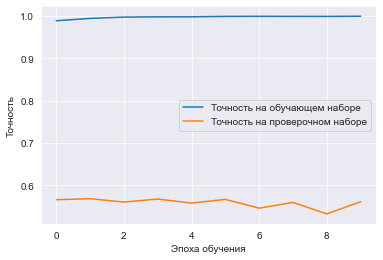

In [31]:
plot_history_nn(history)

In [35]:
y_pred = simple_model.predict(X_val)

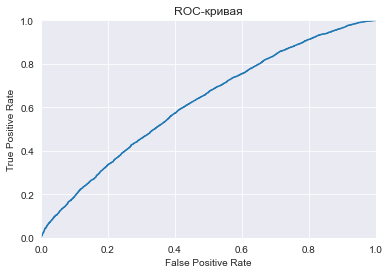

ROC-AUC Score: 0.6227469834398804


In [38]:
plot_roc_curve(y_pred, y_val)

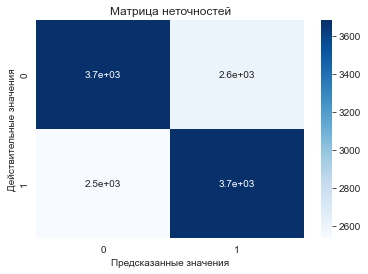

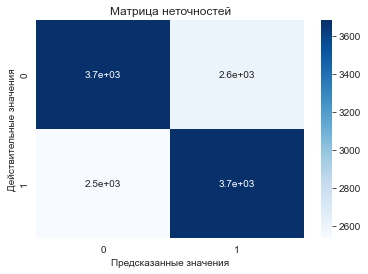

In [37]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)